# CODE BLOCKS TO GET BEST DROP OUT RATE FOR OUR MODEL

<p>In this part we are trying different drop out rate and the final summary is reported in CM3</p>

### DATASET PREPARATION

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

In [2]:
dataset = pd.read_csv("COVID_dataset_train.csv")

In [3]:
# replacing NaN in Outbreak_Related with NO 
dataset['Outbreak_Related'] = dataset['Outbreak_Related'].fillna("No") 

# Dropping NaN values in Age_Group, Test_reported_date and specimen_date
dataset = dataset.dropna()

In [4]:
dataset.Accurate_Episode_Date = pd.to_datetime(dataset.Accurate_Episode_Date)
dataset.Case_Reported_Date = pd.to_datetime(dataset.Case_Reported_Date)
dataset.Test_Reported_Date = pd.to_datetime(dataset.Test_Reported_Date)
dataset.Specimen_Date = pd.to_datetime(dataset.Specimen_Date)

dataset = dataset.drop(['Test_Reported_Date', 'Specimen_Date'],axis=1)

In [5]:
dataset.Case_Reported_Date = list(map(lambda x: x.timestamp(),dataset.Case_Reported_Date))
dataset.Accurate_Episode_Date = list(map(lambda x: x.timestamp(),dataset.Accurate_Episode_Date))

In [6]:
## encoding of target variable
dataset_target = dataset['Outcome1']
dataset_target = pd.DataFrame(dataset_target, columns = ['Outcome1'])

categorical_cols = ['Outcome1']

# Create the encoder.
encoder_1 = OneHotEncoder(categories = "auto", handle_unknown="error", sparse = False)

# Fit and transform encoder to X
array_hot_encoded_1 = encoder_1.fit_transform(dataset_target)

# convert it to a Data Frame
data_hot_encoded_1 = pd.DataFrame(array_hot_encoded_1, index=dataset_target.index)

# set column names of encoded dataframe
data_hot_encoded_1.columns = encoder_1.get_feature_names(categorical_cols)

dataset_target_1 = data_hot_encoded_1

In [7]:
## encoding of features
dataset_features = dataset.drop(['Outcome1'], axis = 1)

dataset_features['Age_Group'] = dataset_features['Age_Group'].replace({'<20': 1, '20s': 2, '30s': 3 , '40s': 4, '50s': 5, '60s': 6, '70s': 7, '80s': 8, '90s': 9})

categorical_cols = ['Client_Gender','Case_AcquisitionInfo','Reporting_PHU_City','Outbreak_Related']

# Create the encoder.
encoder = OneHotEncoder(categories = "auto", handle_unknown="error", sparse = False)

# Fit and transform encoder to X
array_hot_encoded = encoder.fit_transform(dataset_features[categorical_cols])

# convert it to a Data Frame
data_hot_encoded = pd.DataFrame(array_hot_encoded, index=dataset.index)

# set column names of encoded dataframe
data_hot_encoded.columns = encoder.get_feature_names(categorical_cols)

# concatenate other columns with the encoded columns to get the final datset
data_other_cols = dataset_features.drop(columns=categorical_cols)
dataset_temp = pd.concat([data_hot_encoded, data_other_cols], axis=1)
dataset_features = dataset_temp

In [8]:
X_train, X_test, y_train, y_test = train_test_split(dataset_features, dataset_target_1, test_size = 0.10)

In [9]:
from sklearn.preprocessing import StandardScaler
numeric_columns = ['Reporting_PHU_Longitude', 'Reporting_PHU_Latitude','Case_Reported_Date', 'Accurate_Episode_Date']

sc = StandardScaler()

X_train_scaled = X_train.copy()


X_train_scaled[numeric_columns] = sc.fit_transform(X_train[numeric_columns])


In [10]:
X_test_scaled = X_test.copy()
X_test_scaled[numeric_columns] = sc.transform(X_test[numeric_columns])

### TRAINING THE MODEL AT DIFFERENT DROP OUT RATE

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

dr = [0.01, 0.015, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75]

val_loss = []
val_acc = []
train_acc = []
train_loss = []

for i in range(len(dr)):
    # INITIALING ANN
    ann = tf.keras.models.Sequential()

    # ADDING INPUT LAYER AND FIRST HIDDEN LAYER
    ann.add(tf.keras.layers.Dense(units = 112, activation='relu'))
    ann.add(Dropout(dr[i]))

    # ADDING SECOND HIDDEN LAYER
    ann.add(tf.keras.layers.Dense(units=448, activation='relu', kernel_regularizer=l2(0.001)))

    # ADDING THIRD HIDDEN LAYER
    ann.add(tf.keras.layers.Dense(units=56, activation='relu'))

    # ADDING OUTPUT LAYER
    ann.add(tf.keras.layers.Dense(units=3, activation='softmax'))

    opt = tf.keras.optimizers.Adam(learning_rate= 0.001)

    ann.compile(optimizer=opt , loss='categorical_crossentropy', metrics=['accuracy'])
    
    callback = EarlyStopping(monitor='val_loss', patience = 10)

    fitted_model = ann.fit(X_train_scaled, y_train, validation_split = 0.15, callbacks = [callback], epochs= 400, verbose=0)
    
    val_loss.append(np.mean(fitted_model.history['val_loss']))
    val_acc.append(np.mean(fitted_model.history['val_accuracy']))
    train_acc.append(np.mean(fitted_model.history['accuracy']))
    train_loss.append(np.mean(fitted_model.history['loss']))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended

<AxesSubplot:title={'center':'Drop-out rate v/s training accuracy'}, xlabel='Drop-out rate', ylabel='accuracy in %'>

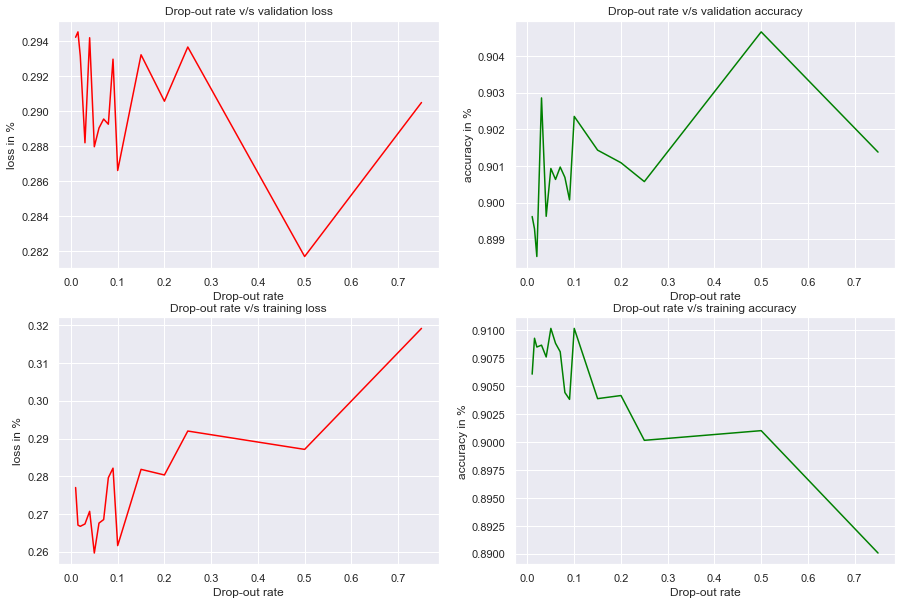

In [12]:
fig = plt.figure(figsize=(15,10))

plt.subplot(221)
plt.title("Drop-out rate v/s validation loss")
plt.xlabel('Drop-out rate')
plt.ylabel('loss in %')
sns.lineplot(x = dr, y = val_loss, color = 'red')

plt.subplot(222)
plt.title("Drop-out rate v/s validation accuracy")
plt.xlabel('Drop-out rate')
plt.ylabel('accuracy in %')
sns.lineplot(x = dr, y = val_acc, color = 'green')

plt.subplot(223)
plt.title("Drop-out rate v/s training loss")
plt.xlabel('Drop-out rate')
plt.ylabel('loss in %')
sns.lineplot(x = dr, y = train_loss, color = 'red')

plt.subplot(224)
plt.title("Drop-out rate v/s training accuracy")
plt.xlabel('Drop-out rate')
plt.ylabel('accuracy in %')
sns.lineplot(x = dr, y = train_acc, color = 'green')

<P>Final comparison of results and run time performance are reported in a tabular form in CM3</P>